## Part IV.1: Experiments with CNN Model Architecture

In this section, experiments and tuning exercises will be conducted using CNN foundational model architecture.  This will include the following:

1.  Experiments with different CNN model architectures (number of conv layers, etc.)
2.  Experiments with regularization methods (if necessary) including dropout layers, batch normalization, etc.
3.  Hyperparameter tuning/optimization

In [1]:
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, ConfusionMatrixDisplay, confusion_matrix

### Load Prepared Datasets

In [2]:
LOAD_FROM_GDRIVE = True

In [3]:
if(LOAD_FROM_GDRIVE):
    # mount google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')

    dataset_root = '/content/drive/MyDrive/Datasets/sepsis/prepared'

    X_train = np.load(os.path.join(dataset_root, 'X_train.npy'))
    y_train = np.load(os.path.join(dataset_root, 'y_train.npy'))

    X_test = np.load(os.path.join(dataset_root, 'X_test.npy'))
    y_test = np.load(os.path.join(dataset_root, 'y_test.npy'))

    X_val =  np.load(os.path.join(dataset_root, 'X_val.npy'))
    y_val = np.load(os.path.join(dataset_root, 'y_val.npy'))

else:
    # load from datalake (S3)
    !aws s3 cp $s3_datalake_path_prepared $local_data_path_csv --recursive --exclude "*" --include "*.npy"

    X_train = np.load(os.path.join(local_data_path_csv, 'X_train.npy'))
    y_train = np.load(os.path.join(local_data_path_csv, 'y_train.npy'))

    X_test = np.load(os.path.join(local_data_path_csv, 'X_test.npy'))
    y_test = np.load(os.path.join(local_data_path_csv, 'y_test.npy'))

    X_val =  np.load(os.path.join(local_data_path_csv, 'X_val.npy'))
    y_val = np.load(os.path.join(local_data_path_csv, 'y_val.npy'))

Mounted at /content/drive


In [4]:
# inspect the loaded data
print(f"Train data shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Test data shape: X: {X_test.shape}, y: {y_test.shape}")
print(f"Validation data shape: X: {X_val.shape}, y: {y_val.shape}")

Train data shape: X: (3105, 48, 51), y: (3105,)
Test data shape: X: (388, 48, 51), y: (388,)
Validation data shape: X: (389, 48, 51), y: (389,)


In [5]:
# refactor targets to work for modeling
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [21]:
# global default training parameters
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.005

# calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.reshape(-1,))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6933899062081287, 1: 1.7927251732101617}

In [7]:
y_train.sum() / len(y_train)

0.2789049919484702

In [8]:
y_val.sum() / len(y_val)

0.2570694087403599

In [9]:
y_val.sum()

100

### Helper Functions for Training

In [18]:
# compile and train model
def compile_and_train_adam(model, checkpoint_callback):
  # Compile the model
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
  )
  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, class_weight=class_weights, callbacks=[checkpoint_callback])
  return history

# plot loss curves
def plot_loss(history, title, ignore_first=False):
  start_idx = 0
  if(ignore_first):
    start_idx = 1

  plt.plot(history.history['loss'][start_idx:])
  plt.plot(history.history['val_loss'][start_idx:])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Tain', 'Val'])
  plt.show()

# run forward pass and plot confusion matrix
def predict_and_plot_confusion(model, title):
  y_pred = model.predict(X_val)
  cm = confusion_matrix(y_val, np.round(y_pred).tolist())
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  plt.title(title)

### Baseline CNN Model

In [11]:
# setup checkpoint
checkpoint_filepath = '/content/drive/MyDrive/Datasets/sepsis/models/cnn-1.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

cnn_baseline = tf.keras.Sequential([

  tf.keras.layers.Input(shape=X_train.shape[1:]),

  tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
# Train the model
history_cnn_baseline = compile_and_train_adam(cnn_baseline, model_checkpoint_callback)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - binary_accuracy: 0.6903 - f1_score: 0.4514 - loss: 0.6862 - precision: 0.4873 - recall: 0.6422 - val_binary_accuracy: 0.8663 - val_f1_score: 0.4090 - val_loss: 0.3979 - val_precision: 0.7449 - val_recall: 0.7300
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8773 - f1_score: 0.4329 - loss: 0.3775 - precision: 0.7626 - recall: 0.8074 - val_binary_accuracy: 0.8638 - val_f1_score: 0.4090 - val_loss: 0.3356 - val_precision: 0.7582 - val_recall: 0.6900
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9033 - f1_score: 0.4138 - loss: 0.3028 - precision: 0.8032 - recall: 0.8415 - val_binary_accuracy: 0.8946 - val_f1_score: 0.4090 - val_loss: 0.2923 - val_precision: 0.8041 - val_recall: 0.7800
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8893 - f1_score: 0.4363 - loss: 0.3294 - precision: 0.7767 - recall: 0.8473 - val_binary_accuracy: 0.8560 - val_f1_score: 0.4090 - val_l

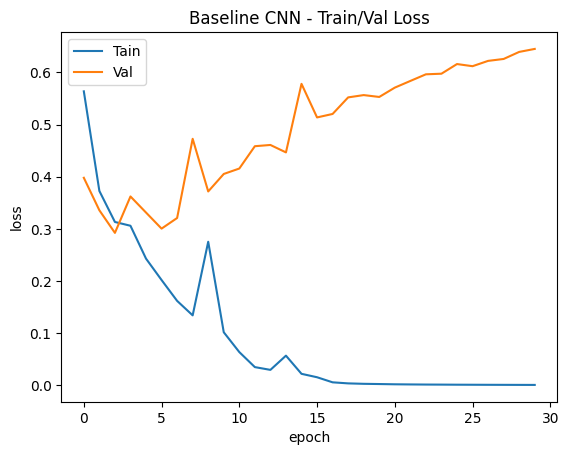

In [19]:
#plot loss
plot_loss(history_cnn_baseline, 'Baseline CNN - Train/Val Loss')

### Experiment 1: Deeper Model with Regularization

In [22]:
# setup checkpoint
checkpoint_filepath = '/content/drive/MyDrive/Datasets/sepsis/models/cnn-e1.keras'
model_checkpoint_callback_c1 = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

cnn_e1 = tf.keras.Sequential([

  tf.keras.layers.Input(shape=X_train.shape[1:]),
  tf.keras.layers.Normalization(axis=None),

  tf.keras.layers.Conv1D(512, kernel_size=3, activation='relu', padding='causal'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Conv1D(512, kernel_size=3, activation='relu', padding='causal'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu', padding='causal', kernel_regularizer = tf.keras.regularizers.l1(0.01)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu', padding='causal', kernel_regularizer = tf.keras.regularizers.l1(0.01)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.MaxPooling1D(2),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
cnn_e1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 48, 51)              │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 48, 512)             │          78,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 48, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 24, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 24, 512)             │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 24, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 12, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 12, 256)             │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 12, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 6, 256)              │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,719,044 (6.56 MB)

 Trainable params: 1,719,041 (6.56 MB)

 Non-trainable params: 3 (16.00 B)

In [24]:
# Train the model
history_cnn_e1 = compile_and_train_adam(cnn_e1, model_checkpoint_callback_c1)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - binary_accuracy: 0.4624 - f1_score: 0.4313 - loss: 62.9656 - precision_2: 0.2707 - recall_2: 0.5589 - val_binary_accuracy: 0.5219 - val_f1_score: 0.4090 - val_loss: 5.8749 - val_precision_2: 0.3320 - val_recall_2: 0.8500
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.6609 - f1_score: 0.4291 - loss: 5.0442 - precision_2: 0.4437 - recall_2: 0.7270 - val_binary_accuracy: 0.7584 - val_f1_score: 0.4090 - val_loss: 4.1509 - val_precision_2: 0.5221 - val_recall_2: 0.7100
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.7505 - f1_score: 0.4331 - loss: 4.1172 - precision_2: 0.5366 - recall_2: 0.7767 - val_binary_accuracy: 0.8226 - val_f1_score: 0.4090 - val_loss: 3.9945 - val_precision_2: 0.6598 - val_recall_2: 0.6400
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.8120 - f1_score: 0.4244 - loss: 3.9945 - precision_2: 0.6119 - recall_2: 0.8331 - val_binary_accuracy: 0.8

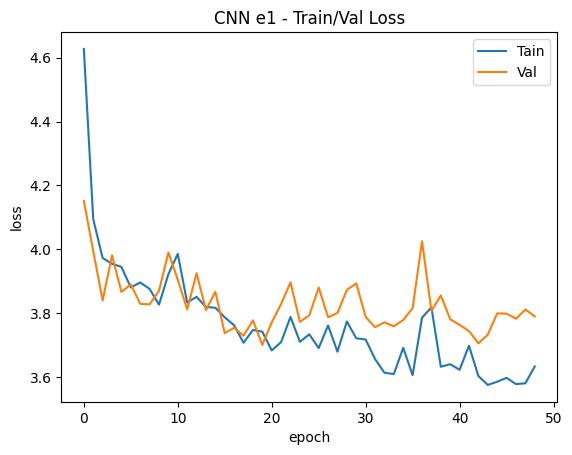

In [25]:
#plot loss
plot_loss(history_cnn_e1, 'CNN e1 - Train/Val Loss', True)

In [26]:
# load best checkpoint
cnn_e1_best = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/sepsis/models/cnn-e1.keras')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


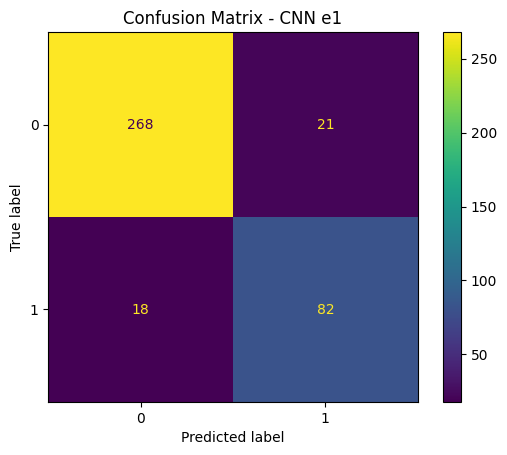

In [27]:
predict_and_plot_confusion(cnn_e1_best, "Confusion Matrix - CNN e1")

In [33]:
results = cnn_e1_best.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(f"Loss: {results[0]}")
print(f"Binary Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")
print(f"F1 Score: {results[4]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9030 - f1_score: 0.3978 - loss: 3.6872 - precision_2: 0.7983 - recall_2: 0.8151 
Loss: 3.700857639312744
Binary Accuracy: 0.8997429013252258
Precision: 0.7961165308952332
Recall: 0.8199999928474426
F1 Score: 0.40899792313575745


### Experiment 3: Shallow Model with Regularization

In [47]:
# setup checkpoint
checkpoint_filepath = '/content/drive/MyDrive/Datasets/sepsis/models/cnn-e2.keras'
model_checkpoint_callback_c2 = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

cnn_e2 = tf.keras.Sequential([

  tf.keras.layers.Input(shape=X_train.shape[1:]),
  tf.keras.layers.Normalization(axis=None),

  tf.keras.layers.Conv1D(512, kernel_size=3, activation='relu', padding='causal'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.AveragePooling1D(2),

  tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='causal', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.AveragePooling1D(2),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [48]:
# display model summary
cnn_e2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization)      │ (None, 48, 51)              │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 48, 512)             │          78,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 48, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_13                 │ (None, 24, 512)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 24, 128)             │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_14                 │ (None, 12, 128)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 735,108 (2.80 MB)

 Trainable params: 735,105 (2.80 MB)

 Non-trainable params: 3 (16.00 B)

In [49]:
# Train the model
history_cnn_e2 = compile_and_train_adam(cnn_e2, model_checkpoint_callback_c2)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - binary_accuracy: 0.6576 - f1_score: 0.4406 - loss: 2.0195 - precision_4: 0.4161 - recall_4: 0.5385 - val_binary_accuracy: 0.8432 - val_f1_score: 0.4090 - val_loss: 0.7142 - val_precision_4: 0.7468 - val_recall_4: 0.5900
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8301 - f1_score: 0.4358 - loss: 0.7120 - precision_4: 0.6749 - recall_4: 0.7540 - val_binary_accuracy: 0.8715 - val_f1_score: 0.4090 - val_loss: 0.5252 - val_precision_4: 0.7500 - val_recall_4: 0.7500
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8485 - f1_score: 0.4373 - loss: 0.5335 - precision_4: 0.6980 - recall_4: 0.8074 - val_binary_accuracy: 0.8895 - val_f1_score: 0.4090 - val_loss: 0.4293 - val_precision_4: 0.8000 - val_recall_4: 0.7600
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8790 - f1_score: 0.4255 - loss: 0.4600 - precision_4: 0.7529 - recall_4: 0.8235 - val_binary_accuracy: 0.8895 

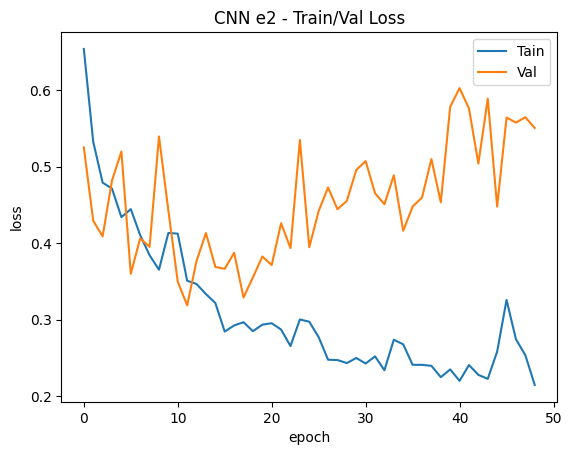

In [50]:
#plot loss
plot_loss(history_cnn_e2, 'CNN e2 - Train/Val Loss', True)

In [51]:
# load best checkpoint
cnn_e2_best = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/sepsis/models/cnn-e2.keras')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


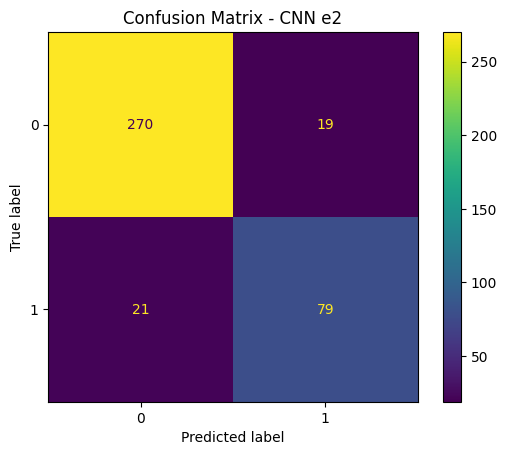

In [52]:
predict_and_plot_confusion(cnn_e2_best, "Confusion Matrix - CNN e2")

In [53]:
results = cnn_e2_best.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(f"Loss: {results[0]}")
print(f"Binary Accuracy: {results[1]}")
print(f"Precision: {results[2]}")
print(f"Recall: {results[3]}")
print(f"F1 Score: {results[4]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - binary_accuracy: 0.9001 - f1_score: 0.3978 - loss: 0.3146 - precision_4: 0.8000 - recall_4: 0.7972
Loss: 0.31881147623062134
Binary Accuracy: 0.897172212600708
Precision: 0.8061224222183228
Recall: 0.7900000214576721
F1 Score: 0.40899792313575745
